In [1]:
import sys
sys.path.append('../Codes/')
import numpy as np
import matplotlib.pyplot as plt
from Immuno_models import*
from Bio import Phylo
from io import StringIO
from matplotlib.lines import Line2D
from datetime import datetime, timedelta
import scipy.special as sc
import os.path
import pickle
from matplotlib import style
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from IPython.display import display, Math

def linear_func(x, a, b):
    return a + b*x

N_A = 6.02214076e23
k_BT = 1.380649e-23*293
style.use('seaborn-paper')
print(style.available)
%autosave 60

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


Autosaving every 60 seconds


## Generating Sequences

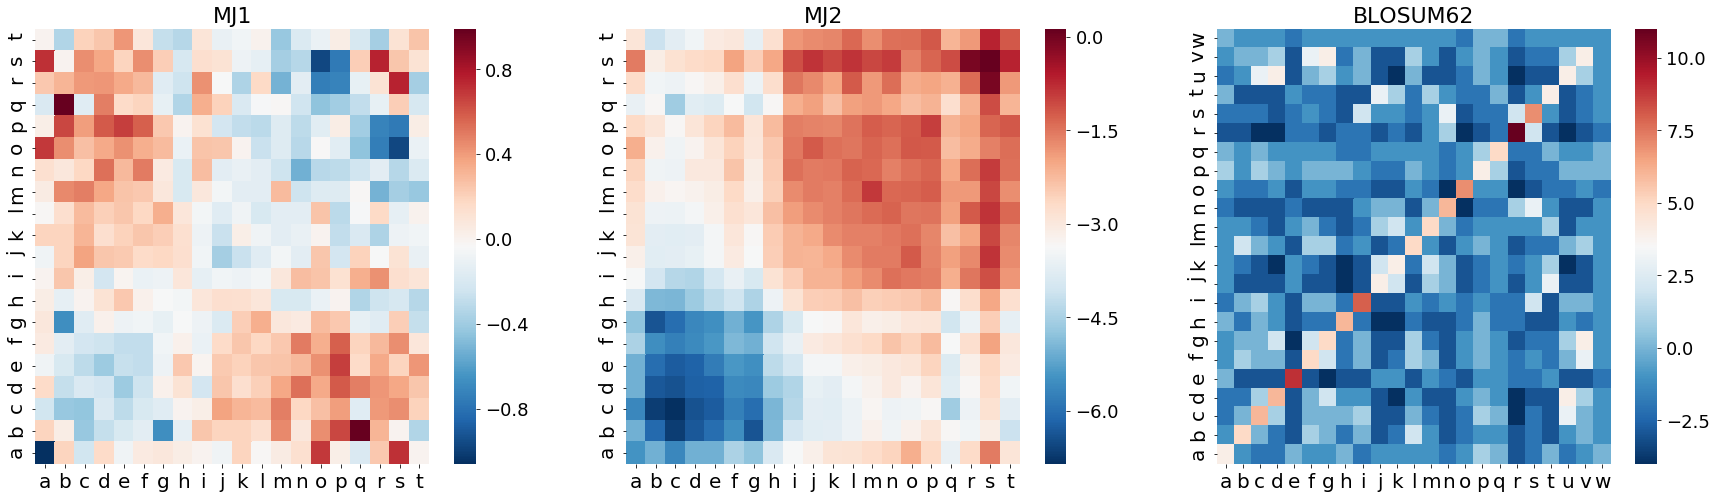

In [2]:
M1 = np.loadtxt('../Text_files/MJ.txt', skiprows= 1, usecols=range(1,21)).tolist()
M2 = (np.loadtxt('../Text_files/MJ2.txt', skiprows= 1, usecols=range(1,21))).tolist()
M3 = np.loadtxt('../Text_files/BLOSUM62.txt', skiprows= 1, max_rows = 23, usecols=range(1,24)).tolist()
Alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't']
Alphabet2 = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w']

fig, ax = plt.subplots(1,3,figsize=(30,8))

plot_energy_matrix(Energy_Matrix = M1, Alphabet = Alphabet, title = 'MJ1', ax = ax[0])
plot_energy_matrix(Energy_Matrix = M2, Alphabet = Alphabet, title = 'MJ2', ax = ax[1])
plot_energy_matrix(Energy_Matrix = M3, Alphabet = Alphabet2, title = 'BLOSUM62', ax = ax[2])

fig.savefig('../Figures/Energy_matrices.png')

In [3]:
%%time
n_seq = 500000

#Sequences = generate_Sequences(n_seq, Energy_Matrix = )
#pickle.dump( Sequences, open( "../Text_files/Sequences-n_seq-%d.pkl"%(n_seq), "wb" ) )

Sequences = pickle.load( open( "../Text_files/Sequences_MJ2-n_seq-%d.pkl"%(n_seq), "rb" ) )

#print_raw_file(Sequences, "../Text_files/file2.txt")
#generate_newick_format("../Text_files/file2.txt")



CPU times: user 3.58 s, sys: 356 ms, total: 3.94 s
Wall time: 3.8 s


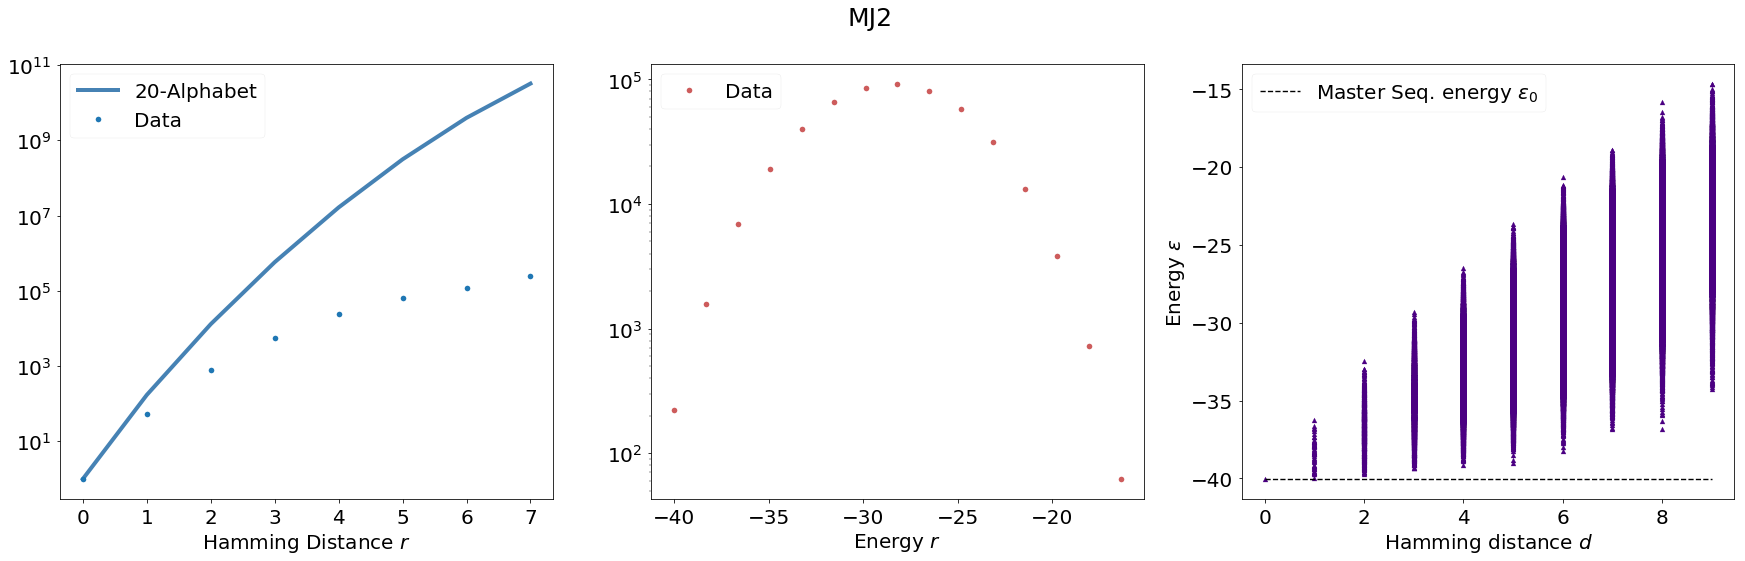

In [4]:
fig, ax = plt.subplots(1,3,figsize=(30,8))
fig.suptitle('MJ2', fontsize = 25)
distances = plot_histogram_hamming_distance(Sequences = Sequences, ax = ax[0])
energies = plot_histogram_energy(Sequences = Sequences, bins = 15, ax = ax[1])
plot_scatter_hamming_distance_energy(distances = distances, energies = energies, ax = ax[2])

fig.savefig('../Figures/Sequences_MJ2-n_seq-%d.png'%(n_seq))


# Deterministic Simulation

In [8]:
%%time
n_linages = 200
U = n_linages/n_seq
nu = 1
R=6
beta = 1
gamma = 1
T = 23
master_Sequence_energy = 0
dt = 0.01
Sub_Sequences = np.random.choice(Sequences, n_linages)
Model  = Deterministic_simulation(Sequences = Sub_Sequences, n_linages=n_linages, T = T, U = U, gamma = gamma, 
                                  nu = nu, R = R, beta = beta, master_Sequence_energy = master_Sequence_energy, 
                                  dt = dt)
Model.ODE()


CPU times: user 2.5 s, sys: 8.47 ms, total: 2.51 s
Wall time: 2.52 s


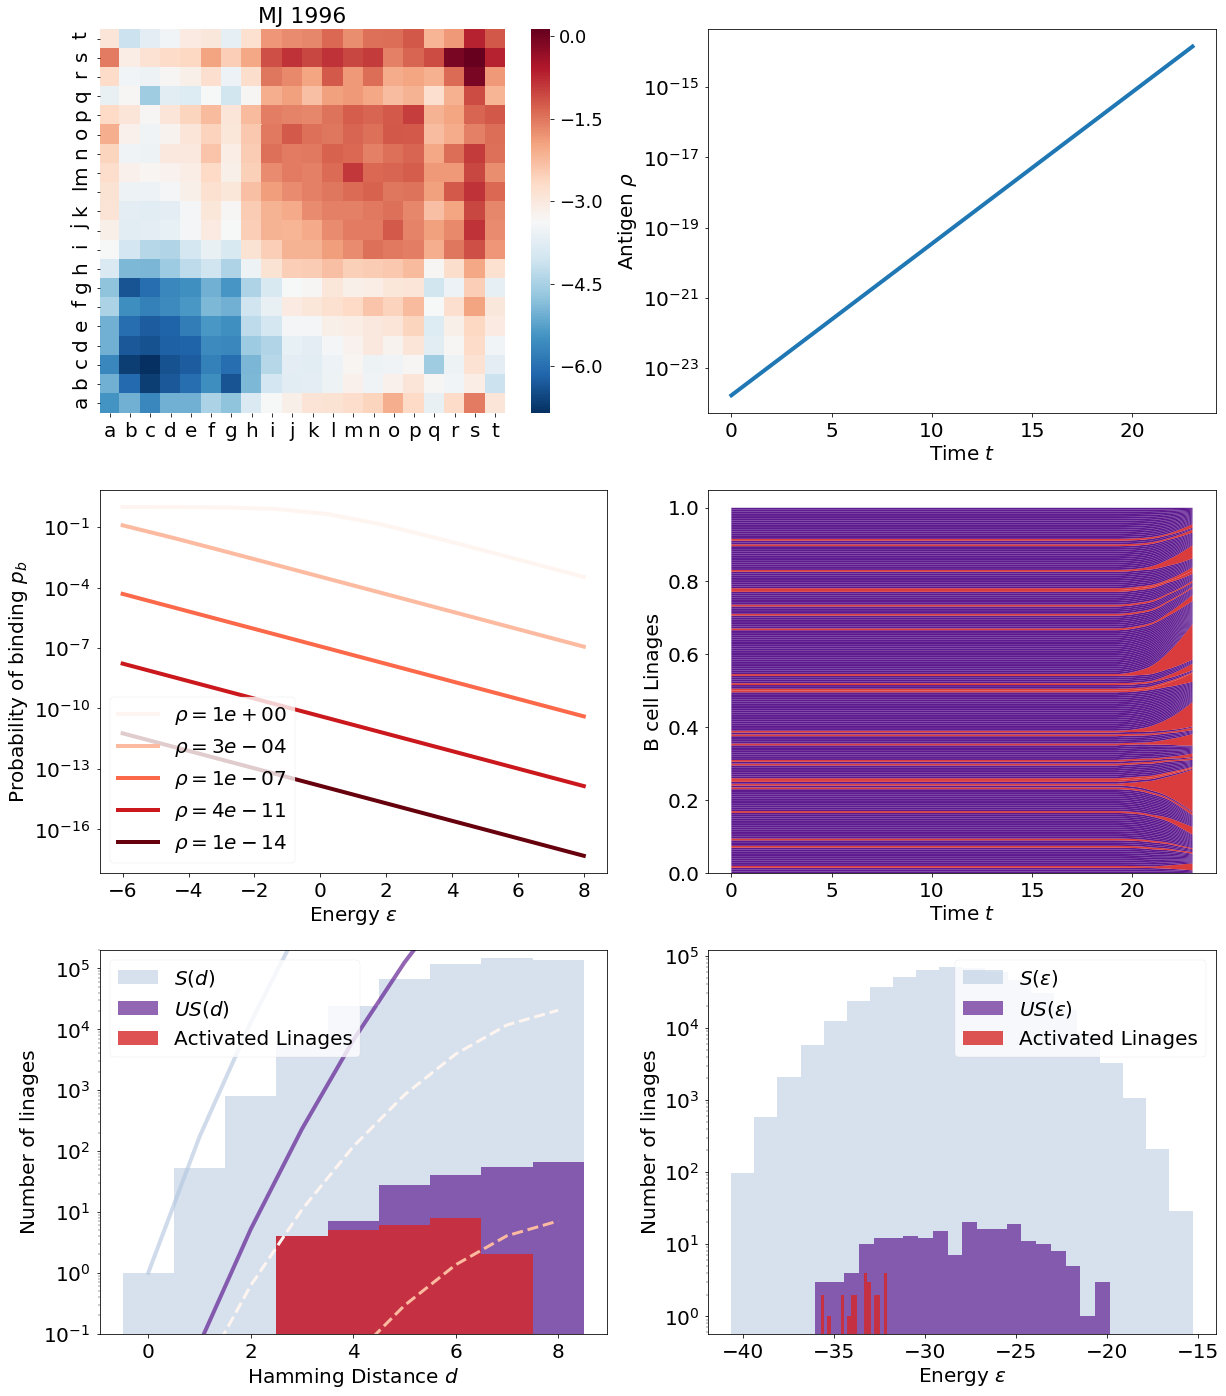

In [9]:
fig, ax = plt.subplots(3,2,figsize=(20,24))

plot_energy_matrix(Energy_Matrix=M2, Alphabet = Alphabet, title = 'MJ 1996', ax = ax[0,0])
Model.plot_antigen_time(ax = ax[0,1])
Model.plot_prob_binding(ax = ax[1,0])
Model.stackplot_linages_time(antigen = False, time = True, ax = ax[1,1])
Model.hist_sequences_hamming_distance(Sequences = Sequences, ax = ax[2,0])
Model.hist_sequences_energy(Sequences = Sequences, bins = 20, ax = ax[2,1])


counter = 0
while(os.path.isfile('../Figures/Antigen_Linages_%d.png'%(counter))):
    counter+=1
    
#fig.savefig('../Figures/Antigen_Linages_%d.png'%(counter))



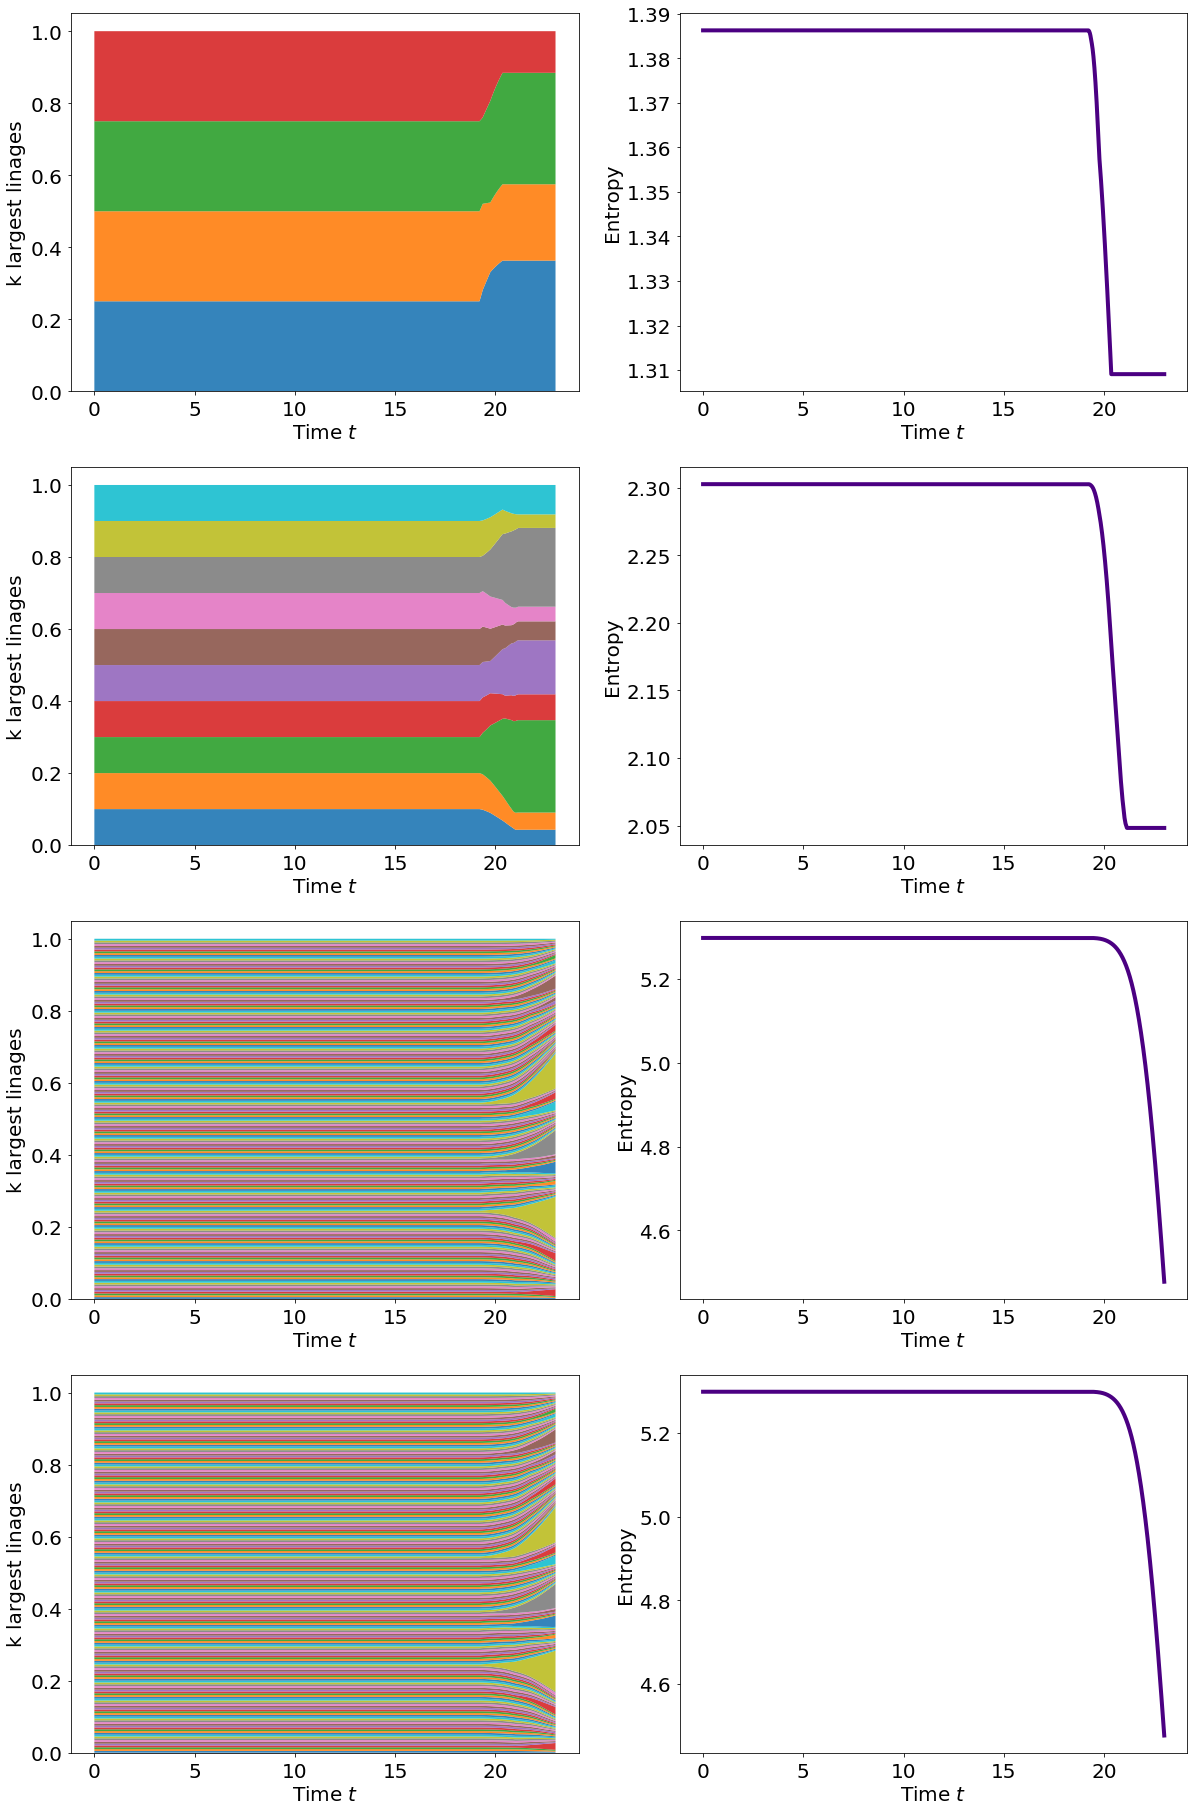

In [10]:
fig, ax = plt.subplots(4,2,figsize=(20,32))

for i, k in enumerate([4, 10, 50, 100]):

    biggest_k_linages_freq = Model.plot_k_largest_linages(k=k, ax=ax[i,0])
    Model.plot_entropy_k_largest_linages(k=k, biggest_k_linages_freq = biggest_k_linages_freq, ax=ax[i,1])

counter = 0
while(os.path.isfile('../Figures/Entropy_%d.png'%(counter))):
    counter+=1
    
#fig.savefig('../Figures/Entropy_%d.png'%(counter))



## Stochastic Simulation - Stochastic antigen dynamics

In [8]:
%%time
n_linages = 200
U = n_linages/n_seq
nu = 0.0004
R=6
beta = 0.001
gamma = 1
T = 5
master_Sequence_energy = 0
Sub_Sequences = np.random.choice(Sequences, n_linages)
Model = Stochastic_simulation(Sequences = Sub_Sequences, n_linages=n_linages, T = T, U = U, gamma = gamma,
                              nu = nu, R = R, beta = beta, master_Sequence_energy = master_Sequence_energy)
Model.Gillespie()



CPU times: user 2.41 ms, sys: 177 µs, total: 2.58 ms
Wall time: 2.47 ms


## Plot linages

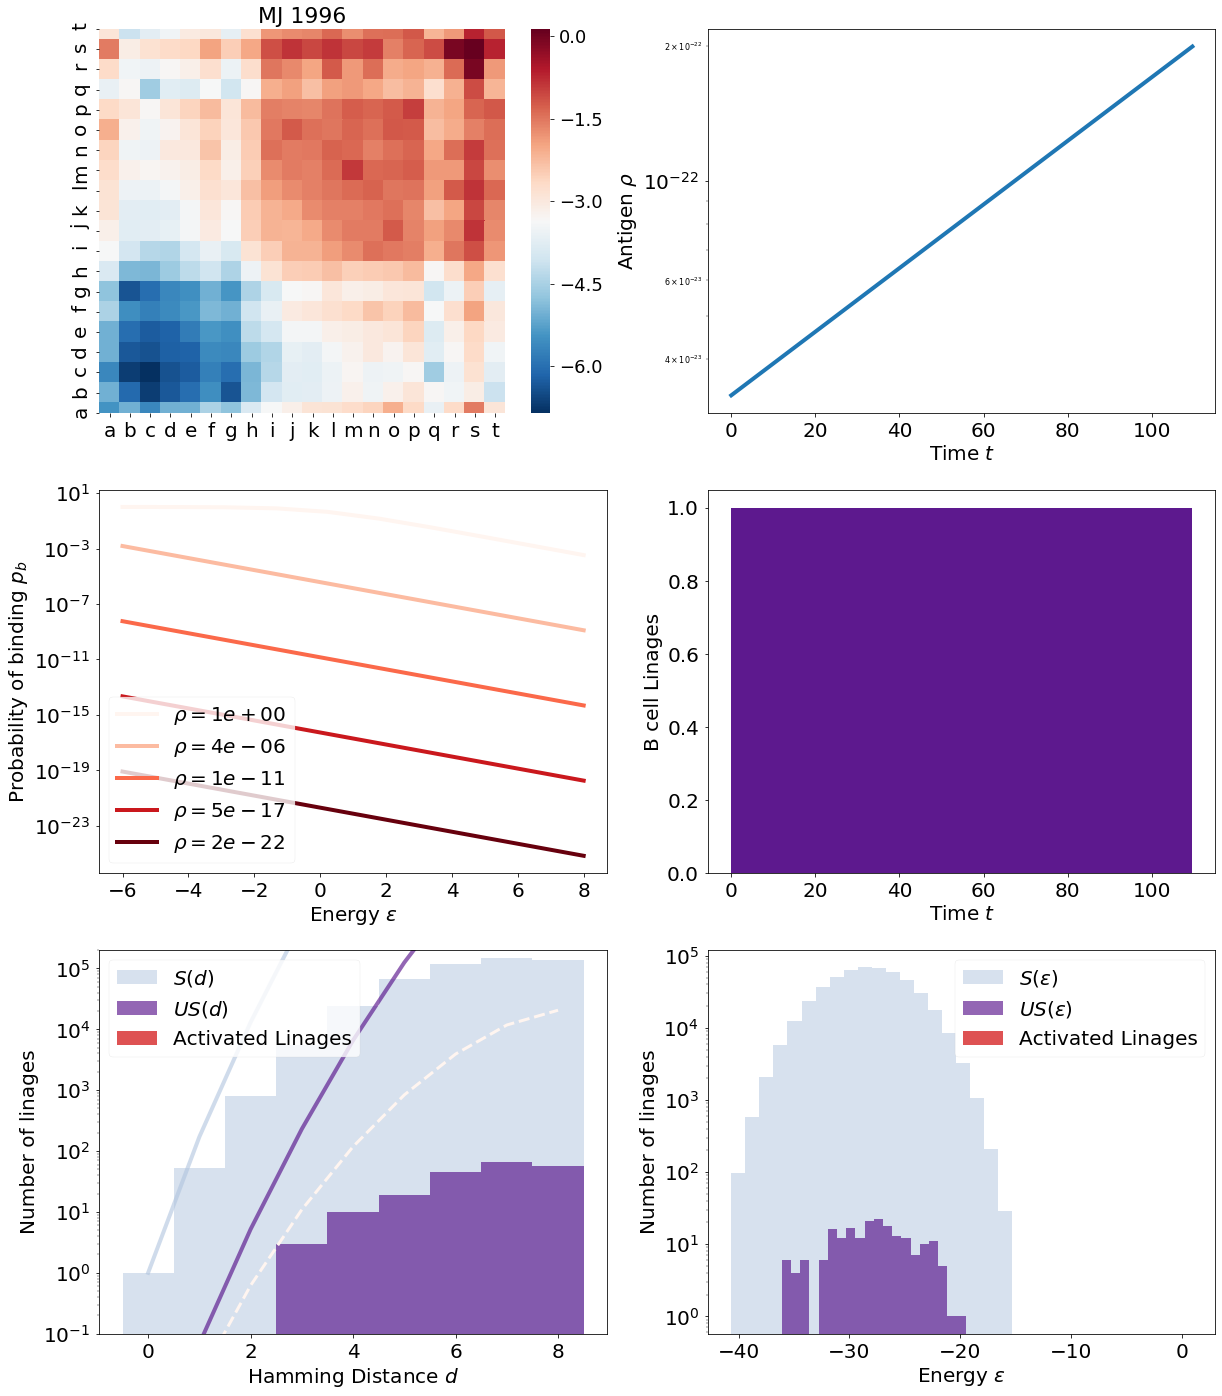

In [9]:
fig, ax = plt.subplots(3,2,figsize=(20,24))

plot_energy_matrix(Energy_Matrix=M2, Alphabet = Alphabet, title = 'MJ 1996', ax = ax[0,0])
Model.plot_antigen_time(ax = ax[0,1])
Model.plot_prob_binding(ax = ax[1,0])
Model.stackplot_linages_time(antigen = False, time = True, ax = ax[1,1])
Model.hist_sequences_hamming_distance(Sequences = Sequences, ax = ax[2,0])
Model.hist_sequences_energy(Sequences = Sequences, bins = 20, ax = ax[2,1])


counter = 0
while(os.path.isfile('../Figures/Antigen_Linages_%d.png'%(counter))):
    counter+=1
    
#fig.savefig('../Figures/Antigen_Linages_%d.png'%(counter))


## entropy

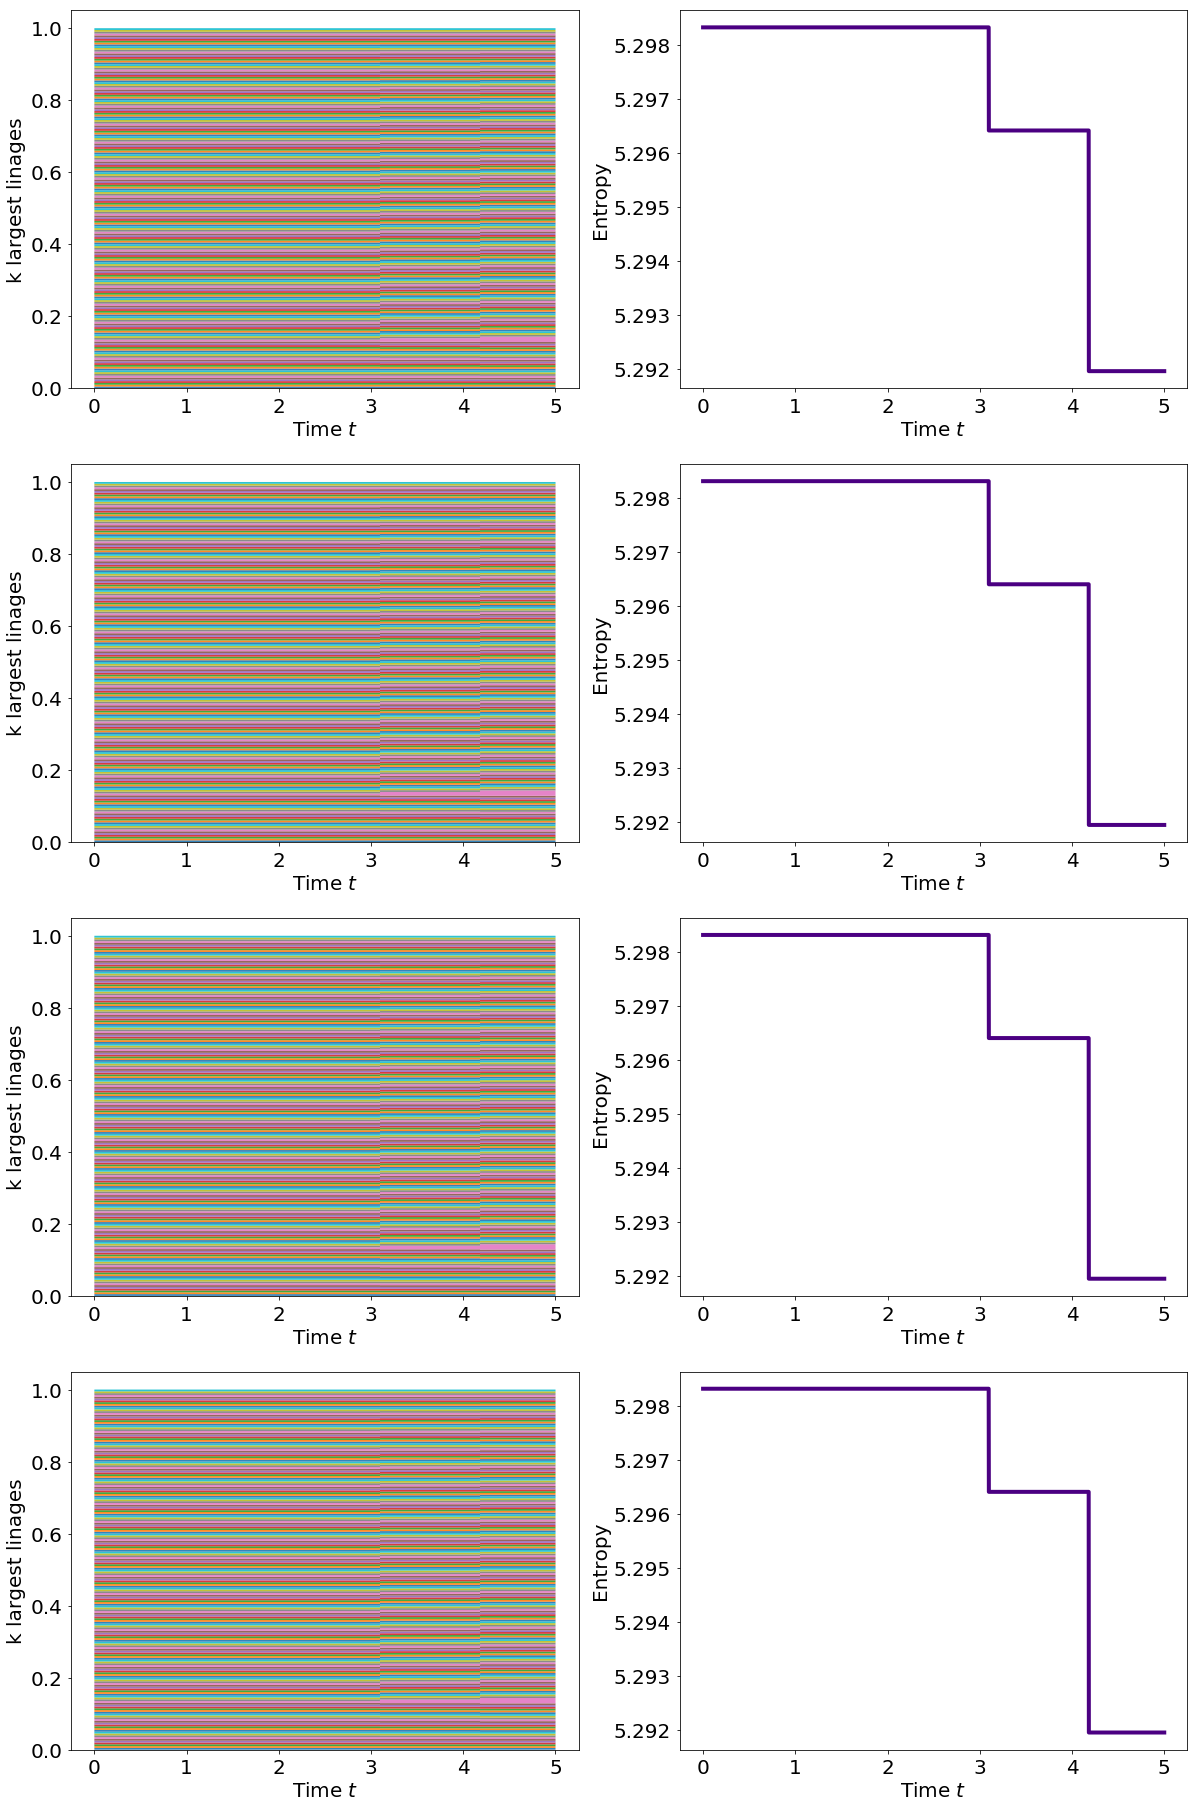

In [27]:
fig, ax = plt.subplots(4,2,figsize=(20,32))

for i, k in enumerate([4, 10, 50, 100]):

    biggest_k_linages_freq = Model.plot_k_largest_linages(k=k, ax=ax[i,0])
    Model.plot_entropy_k_largest_linages(k=k, biggest_k_linages_freq = biggest_k_linages_freq, ax=ax[i,1])

counter = 0
while(os.path.isfile('../Figures/Entropy_%d.png'%(counter))):
    counter+=1
    
#fig.savefig('../Figures/Entropy_%d.png'%(counter))


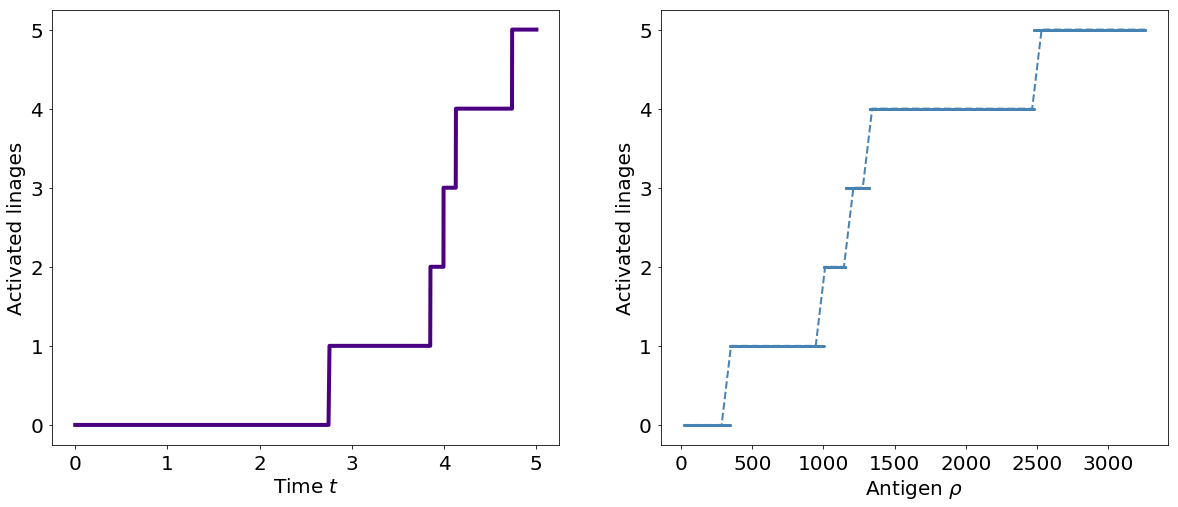

In [28]:
activation_time_series = [np.sum(Model.activation_time_series[:,i]) for i in range(int(len(Model.activation_time_series[0,:])))]
f = interp1d(Model.antigen_time_series, activation_time_series)
x_new = np.linspace(20, np.max(Model.antigen_time_series), 50)

fig, ax = plt.subplots(1,2,figsize=(20,8))

ax[0].plot(Model.time_series, activation_time_series, linewidth = 4, color = 'indigo')
ax[0].set_xlabel(r'Time $t$', fontsize = 20)
ax[0].set_ylabel(r'Activated linages', fontsize = 20)
ax[0].tick_params(labelsize = 20)
#ax[0].set_yscale('log')
#ax[0].legend(loc = 0, fontsize = 20)

ax[1].plot(Model.antigen_time_series, activation_time_series, '.', ms = 5, linewidth = 4, color = 'steelblue')
ax[1].plot(x_new, f(x_new), '--', linewidth = 2, color = 'steelblue')
ax[1].set_xlabel(r'Antigen $\rho$', fontsize = 20)
ax[1].set_ylabel(r'Activated linages', fontsize = 20)
ax[1].tick_params(labelsize = 20)
#ax[1].set_xscale('log')
#ax[1].set_yscale('log')
#ax[1].legend(loc = 0, fontsize = 20)



In [1]:
a = 4

In [3]:
2*(3>a)

0

In [64]:
antigen = 1e8/N_A
display(Math(r'\textrm{Antigen concentration = }%.2e M'%(antigen)))
k_D = np.exp(Sequences[10].energy)
display(Math(r'\epsilon=%.3f'%(Sequences[10].energy)))
display(Math((r'$k_D=%.2e$'%(k_D))))
display(Math(r'f=%.6f'%(antigen/(antigen+k_D))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

1.6605390671738466e-15

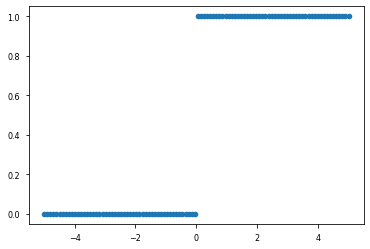

In [17]:
x = np.linspace(-5,5,100)
plt.plot(x, np.heaviside(x,1), 'o')

AttributeError: module 'numpy' has no attribute 'linapce'

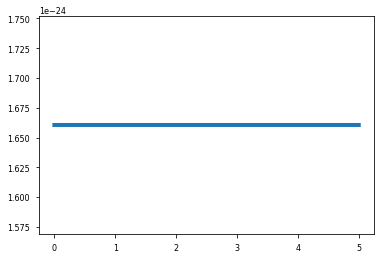

In [10]:
plt.plot(Model.time_series, np.transpose(Model.antigen_time_series)/N_A, linewidth  = 4)

In [15]:
Model.antigen_time_series[0,0:2]

array([1., 1.])